In [ ]:
import os
import contextlib
import itertools
import pickle
import gc
import tensorflow               as tf
import matplotlib.pyplot        as plt
import numpy                    as np
import seaborn                  as sns
from sklearn.metrics.pairwise   import cosine_similarity
from skimage.segmentation       import mark_boundaries
from lime                       import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm

In [ ]:
from labels import class_labels

test_dataset = tf.data.Dataset.load('test_dataset')
test_dataset = test_dataset.shuffle(64)

In [5]:
print(class_labels)

['tench', 'english springer', 'cassette player', 'chain saw', 'church', 'french horn', 'garbage truck', 'gas pump', 'golf ball', 'parachute']


(64, 224, 224, 3)
(64, 10)
Normalized values:  (0.0031250003, 0.9993712)


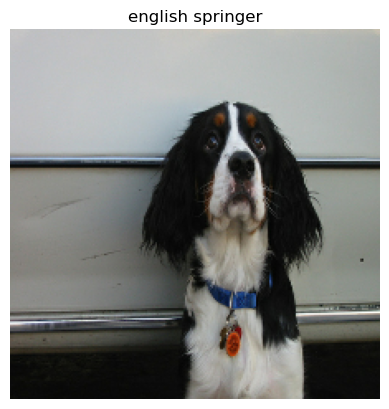

In [41]:
for img_batch, label_batch in test_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)
    img_batch = np.array(img_batch)
    print('Normalized values: ', (np.min(img_batch[3]), np.max(img_batch[0])))
    img = img_batch[3]
    plt.imshow(img)
    plt.title(class_labels[np.argmax(label_batch[3])])
    plt.axis('off')

In [8]:
# Models of Different Architecture
models   = []

save_dir = "models/diff_extrcs"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models.append(model)

In [19]:
model_names = ['Xception', 'InceptionV3', 'DenseNet121', 'ResNet50V2']

for i, model in enumerate(models):
    model._name = model_names[i]
    print(model.name)

Xception
InceptionV3
DenseNet121
ResNet50V2


In [9]:
import helper_functions

sample_lists = [helper_functions.get_sample(class_index=i, dataset=test_dataset) for i in range(10)]

In [10]:
predictions  = [helper_functions.get_predictions(models, sample_list) for sample_list in sample_lists]
new_lists    = [helper_functions.filter_correct_predictions(prediction) for prediction in predictions]

Wrong Prediction at index 4 by Xception_imgnette: Predicted english springer, True tench
Wrong Prediction at index 67 by DenseNet121_imgnette: Predicted chain saw, True tench
Wrong Prediction at index 6 by Xception_imgnette: Predicted gas pump, True cassette player
Wrong Prediction at index 15 by Xception_imgnette: Predicted gas pump, True cassette player
Wrong Prediction at index 19 by Xception_imgnette: Predicted chain saw, True cassette player
Wrong Prediction at index 24 by DenseNet121_imgnette: Predicted french horn, True cassette player
Wrong Prediction at index 40 by InceptionV3_imgnette: Predicted garbage truck, True cassette player
Wrong Prediction at index 45 by DenseNet121_imgnette: Predicted golf ball, True cassette player
Wrong Prediction at index 49 by InceptionV3_imgnette: Predicted chain saw, True cassette player
Wrong Prediction at index 13 by Xception_imgnette: Predicted cassette player, True chain saw
Wrong Prediction at index 27 by Res50_imgnette: Predicted parachut

In [11]:
for ls in new_lists:
    print(len(ls))

66
88
70
63
88
57
70
67
73
86


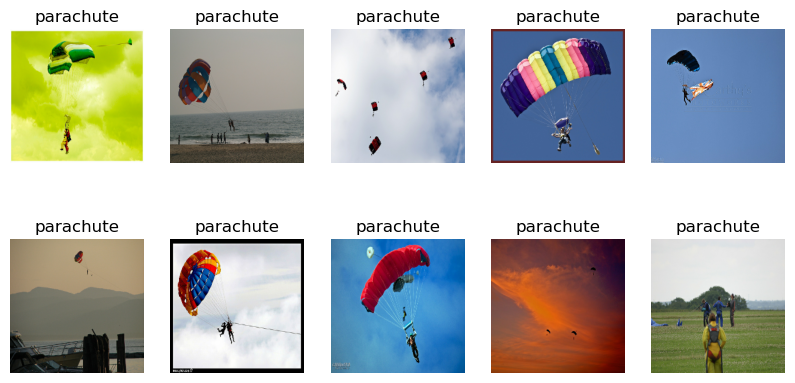

In [12]:
plt.figure(figsize=(10, 5))
class_index = 9

for index, (image, label) in enumerate(new_lists[class_index][:10]):
        plt.subplot(2, 5, index + 1)
        plt.imshow(image.astype("double"))
        plt.title(class_labels[class_index])
        plt.axis("off")
plt.show()

In [13]:
pred_x     = models[0].predict(tf.expand_dims(image, axis=0))
pred_index = np.argmax(pred_x)
print(f"Predicted Index: {class_labels[pred_index]}")
print(f"True Index     : {class_labels[np.argmax(label)]}")

1/1 [==============================] - 0s 79ms/step
Predicted Index: parachute
True Index     : parachute


In [ ]:
%%time
import LIME

save_directory = 'LIME expls/diff_extrcs'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(new_lists, models, 1000, save_directory)

In [ ]:
# With different optimizers
models_opt   = []

save_dir     = "models/diff_optimizers"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        models_opt.append(model)

In [15]:
for model in models_opt:
    print(model.name)

DenseNet121_rmsp
DenseNet121_adam
DenseNet121_SGD
DenseNet121_nadam


In [14]:
preds_opt    = [helper_functions.get_predictions(models_opt, sample_list) for sample_list in sample_lists]
newlists_opt = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_opt]

Wrong Prediction at index 29 by DenseNet121_nadam: Predicted chain saw, True english springer
Wrong Prediction at index 17 by DenseNet121_adam: Predicted golf ball, True cassette player
Wrong Prediction at index 40 by DenseNet121_rmsp: Predicted french horn, True cassette player
Wrong Prediction at index 4 by DenseNet121_SGD: Predicted gas pump, True chain saw
Wrong Prediction at index 5 by DenseNet121_rmsp: Predicted french horn, True chain saw
Wrong Prediction at index 47 by DenseNet121_rmsp: Predicted garbage truck, True chain saw
Wrong Prediction at index 13 by DenseNet121_rmsp: Predicted garbage truck, True church
Wrong Prediction at index 35 by DenseNet121_SGD: Predicted church, True garbage truck
Wrong Prediction at index 59 by DenseNet121_rmsp: Predicted chain saw, True garbage truck
Wrong Prediction at index 5 by DenseNet121_rmsp: Predicted chain saw, True gas pump
Wrong Prediction at index 6 by DenseNet121_adam: Predicted cassette player, True gas pump
Wrong Prediction at ind

In [15]:
for ls in newlists_opt:
    print(len(ls))

63
87
74
65
94
67
74
77
71
76


In [22]:
import LIME
import importlib
importlib.reload(LIME)

<module 'LIME' from '/home/s2310144/workshop/Underspecification/imagenette/LIME.py'>

In [ ]:
%%time
save_directory = 'LIME expls/diff_optimizers'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(newlists_opt, models_opt, 1000, save_directory)

In [25]:
# Models of Different seeds
model_seeds   = []

save_dir      = "models/diff_seeds/"

for model_file in os.listdir(save_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(save_dir, model_file)
        model      = tf.keras.models.load_model(model_path)
        model_seeds.append(model)

In [33]:
for i, model in enumerate(models_seeds):
    model._name = f'Dense{i+1}'
    print(model.name)

Dense1
Dense2
Dense3
Dense4
Dense5
Dense6
Dense7
Dense8
Dense9
Dense10


In [34]:
preds_seed    = [helper_functions.get_predictions(model_seeds, sample_list) for sample_list in sample_lists]
newlists_seed = [helper_functions.filter_correct_predictions(prediction) for prediction in preds_seed]

Wrong Prediction at index 67 by model: Predicted chain saw, True tench
Wrong Prediction at index 46 by model_1: Predicted parachute, True english springer
Wrong Prediction at index 6 by model_3: Predicted gas pump, True cassette player
Wrong Prediction at index 13 by model_1: Predicted gas pump, True cassette player
Wrong Prediction at index 15 by model_4: Predicted gas pump, True cassette player
Wrong Prediction at index 19 by model_3: Predicted chain saw, True cassette player
Wrong Prediction at index 24 by model_1: Predicted french horn, True cassette player
Wrong Prediction at index 40 by model_3: Predicted gas pump, True cassette player
Wrong Prediction at index 45 by model_3: Predicted golf ball, True cassette player
Wrong Prediction at index 57 by model_3: Predicted gas pump, True cassette player
Wrong Prediction at index 62 by model_3: Predicted gas pump, True cassette player
Wrong Prediction at index 11 by model_2: Predicted gas pump, True chain saw
Wrong Prediction at index 1

In [ ]:
%%time
save_directory = 'LIME expls/diff_seeds'

with open(os.devnull, 'w') as f:
    with contextlib.redirect_stdout(f):
        LIME.generate_and_save_explanations(newlists_seed, model_seeds, 1000, save_directory)

In [49]:
import importlib
importlib.reload(LIME)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

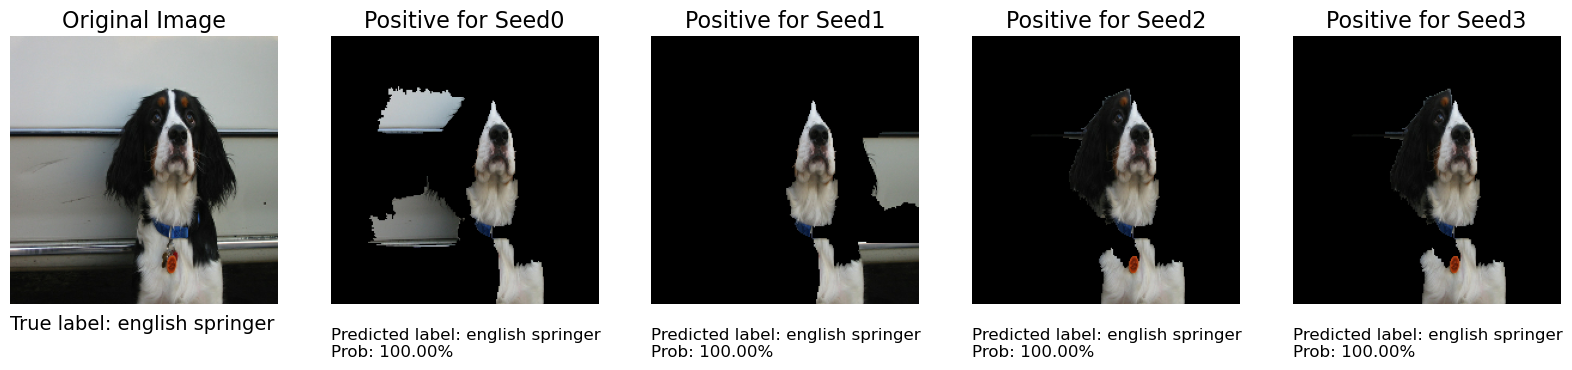

In [59]:
expl_temp = []
expl_mask = []

plt.figure(figsize = (20,20))
plt.subplot(1, 5, 1)
plt.imshow(img)
plt.title(f'Original Image', fontsize=16)
plt.text(0,-0.1,
            f'True label: {class_labels[np.argmax(label_batch[3])]}',
            fontsize  = 14,
            transform = plt.gca().transAxes)
plt.axis('off')

for model_idx, model in enumerate(model_seeds[:4]):
    temp, mask,_ = LIME.explain_aninstance(img, model)
    pred         = LIME.prediction_fn(img, model)
    pred_label   = class_labels[np.argmax(pred)]
    prob         = np.max(pred) * 100
    expl_temp.append(temp)
    expl_mask.append(mask)
    
    plt.subplot(1, 5, model_idx+2)
    plt.imshow(temp)
    plt.title(f'Positive for Seed{model_idx}', fontsize = 16)
    plt.text(0,-0.2,
            f'Predicted label: {pred_label}\nProb: {prob:.2f}%',
            fontsize  = 12,
            transform = plt.gca().transAxes)
    plt.axis('off')

plt.show()